# Εκπαίδευση Μοντέλου Ευθυγράμμισης Ομιλίας–Κειμένου

Σε αυτό το notebook εκπαιδεύουμε ένα **contrastive alignment model** που μαθαίνει να αντιστοιχίζει αναπαραστάσεις ομιλίας (speech embeddings) με αναπαραστάσεις κειμένου (text embeddings) στον ίδιο χώρο.

**Αρχιτεκτονική:**
- **Speech encoder**: Frozen Whisper-tiny — προ-υπολογισμένα hidden states `[B, T, 384]`
- **Text encoder**: Frozen multilingual-e5-small — προ-υπολογισμένα embeddings `[B, 384]`
- **Aligner**: Εκπαιδεύσιμος CNN με multi-kernel convolutions που μετατρέπει τα speech hidden states σε ένα κοινό embedding space
- **Συνάρτηση κόστους**: Symmetric InfoNCE (contrastive loss) με εκπαιδεύσιμη θερμοκρασία $\tau$

**Ροή δεδομένων:**
$$\text{speech\_hidden} \xrightarrow{\text{CNN Aligner}} \text{aligned} \xrightarrow{\text{mean pool}} \text{speech\_emb} \xrightarrow{\ell_2\text{-norm}} \hat{s}$$
$$\text{logits} = \frac{\hat{s} \cdot \hat{t}^\top}{\tau}, \quad \mathcal{L} = \frac{1}{2}\left[\text{CE}(\text{logits}, y) + \text{CE}(\text{logits}^\top, y)\right]$$

## 1. Εισαγωγή Βιβλιοθηκών

Εισάγουμε τις απαραίτητες βιβλιοθήκες:
- **PyTorch** (`torch`, `torch.nn`, `torch.nn.functional`): Για τον ορισμό και εκπαίδευση νευρωνικών δικτύων
- **HuggingFace Transformers**: Για πρόσβαση στα προ-εκπαιδευμένα μοντέλα
- **Εργαλεία επεξεργασίας κειμένου**: `re`, `string`, `unicodedata` για καθαρισμό μεταγραφών

In [1]:
import os
import torch
import torch.nn as nn, torch.nn.functional as F
from datasets import load_from_disk

import lightning as L
from torch.utils.data import Dataset, DataLoader

from models import mean_pooling, AlignmentModel, MlpAdapter, CnnAdapter, LstmAdapter
from preprocess import run as precompute
import evaluate

import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

from lightning.pytorch.loggers import TensorBoardLogger

## 2. Φόρτωση Δεδομένων

Χρησιμοποιούμε το dataset **ddamianos/hparl** (Ελληνικά Κοινοβουλευτικά Πρακτικά) με προ-υπολογισμένα embeddings.

### 2.1 Προεπεξεργασία Κειμένου

Ορίζουμε τη συνάρτηση `preprocess_sentence` για τον καθαρισμό των μεταγραφών:
1. Αφαίρεση tokens `[UNK]`
2. Αφαίρεση σημείων στίξης
3. Κανονικοποίηση Unicode (NFKD)
4. Μετατροπή σε πεζά
5. Αφαίρεση πλεονάζοντων κενών

In [4]:
# Base directory for the dataset
base = "/mnt/h/"

# Path to precomputed dataset
PRECOMPUTED_PATH = f"{base}/hparl-preprocessed"

# HuggingFace caches
os.environ["HF_DATASETS_CACHE"] = f"{base}/datasets"
os.environ["HF_HOME"] = base
os.environ["TRANSFORMERS_CACHE"] = f"{base}/models"

### 2.2 Φόρτωση Προ-υπολογισμένων Embeddings

Φορτώνουμε τo dataset που παρήχθη από το `preprocess.py`. Αν δεν υπάρχει στον δίσκο, εκτελούμε αυτόματα την προεπεξεργασία μέσω `preprocess.run()`.

Περιέχει:

| Στήλη | Σχήμα | Περιγραφή |
|-------|-------|-----------|
| `pooled_speech_embeddings` | `[T, 384]` | Χρονικά pooled hidden states του Whisper encoder |
| `pooled_attn_masks` | `[T]` | Μάσκα προσοχής (1 = πραγματικό frame, 0 = padding) |
| `transcript_embeddings` | `[384]` | L2-κανονικοποιημένα E5 embeddings κειμένου |

Μετατρέπουμε σε format PyTorch tensors με `.with_format('torch')`.

Το `test` split κρατιέται **αποκλειστικά για τελική αξιολόγηση** (evaluation). Κατά την εκπαίδευση, χωρίζουμε το `train` split σε **80% train / 20% validation** για παρακολούθηση του validation loss.

In [5]:
# Load precomputed dataset (whisper hidden states + e5 text embeddings)
# If it doesn't exist on disk, run preprocessing first.
from pathlib import Path
from datasets import load_from_disk

if Path(PRECOMPUTED_PATH).exists():
    print(f"Loading precomputed dataset from {PRECOMPUTED_PATH}")
    ds = load_from_disk(PRECOMPUTED_PATH).with_format('torch')
else:
    print(f"Precomputed dataset not found at {PRECOMPUTED_PATH}, running preprocessing...")
    ds = precompute(base='/mnt/h', save_dir='hparl_precomputed').with_format('torch')
    print("Preprocessing complete.")

# Reserve test split for final evaluation only
test_ds = ds['test']

# Split train into 80% train / 20% validation
split = ds['train'].train_test_split(test_size=0.2, seed=42)
train_ds = split['train']
val_ds = split['test']

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test (held out): {len(test_ds)}")
print(f"Columns: {train_ds.column_names}")
print(f"Speech shape: {train_ds[0]['pooled_speech_embeddings'].shape}")
print(f"Mask shape:   {train_ds[0]['pooled_attn_masks'].shape}")
print(f"Text shape:   {train_ds[0]['transcript_embeddings'].shape}")

Loading precomputed dataset from /mnt/h//hparl-preprocessed


Loading dataset from disk:   0%|          | 0/45 [00:00<?, ?it/s]

Train: 61072, Val: 15269, Test (held out): 8679
Columns: ['pooled_speech_embeddings', 'pooled_attn_masks', 'transcript_embeddings']
Speech shape: torch.Size([374, 384])
Mask shape:   torch.Size([374])
Text shape:   torch.Size([384])


## 3. Μοντέλα (από `models.py`)

Οι ορισμοί των μοντέλων βρίσκονται στο αρχείο `models.py` και εισάγονται στο cell 1.

Τα βασικά components:
1. **`mean_pooling`**: Mask-aware μέσος όρος πάνω στη χρονική διάσταση
2. **`CnnAdapter`**: CNN adapter με multi-kernel convolutions — μετατρέπει speech hidden states `[B, T, 384]` → `[B, T', 384]`
3. **`AlignmentModel`**: Δέχεται ένα adapter ως argument, προσθέτει mean pooling + L2 norm + symmetric InfoNCE loss

**Αρχιτεκτονική `CnnAdapter`:**
```
[B, T, 384] → transpose → [B, 384, T]
    → Conv1d(k=3) ⊕ Conv1d(k=5) ⊕ Conv1d(k=7) → [B, 768, T]
    → MaxPool1d → [B, 768, T/2]
    → LayerNorm → (repeat) → [B, 768, T/4]
    → Conv1d(1×1) → [B, 384, T/4]
    → transpose → [B, T/4, 384]
```

**Συνάρτηση κόστους InfoNCE:**

$$\mathcal{L} = \gamma\;\text{CE}\left(\frac{S \cdot T^\top}{\tau},\, y\right) + (1-\gamma)\text{CE}\left(\frac{T \cdot S^\top}{\tau},\, y\right)$$

όπου $S, T \in \mathbb{R}^{B \times D}$ τα κανονικοποιημένα embeddings, $\tau = e^{\log\tau}$ η εκπαιδεύσιμη θερμοκρασία.

## 4. Pipeline Εκπαίδευσης — PyTorch Lightning

Χρησιμοποιούμε **PyTorch Lightning** για τη διαχείριση του training loop.

### 4.1 `PrecomputedDataset` & `collate_fn`

- **`PrecomputedDataset`**: Ελαφρύ `torch.Dataset` wrapper γύρω από ένα HuggingFace split. Μετατρέπει κάθε δείγμα σε `dict` με tensors `speech`, `mask`, `text`.
- **`collate_fn`**: Custom collator που κάνει **padding στη χρονική διάσταση** (τα speech embeddings μπορεί να έχουν διαφορετικό μήκος λόγω της μάσκας) και stack τα text embeddings.

In [6]:
class PrecomputedDataset(Dataset):
    """Thin wrapper around an HF split with precomputed embeddings."""

    def __init__(self, hf_split):
        self.ds = hf_split

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        return {
            'speech': item['pooled_speech_embeddings'].detach().clone() if isinstance(item['pooled_speech_embeddings'], torch.Tensor) else torch.tensor(item['pooled_speech_embeddings'], dtype=torch.float32),
            'mask':   item['pooled_attn_masks'].detach().clone() if isinstance(item['pooled_attn_masks'], torch.Tensor) else torch.tensor(item['pooled_attn_masks'], dtype=torch.long),
            'text':   item['transcript_embeddings'].detach().clone() if isinstance(item['transcript_embeddings'], torch.Tensor) else torch.tensor(item['transcript_embeddings'], dtype=torch.float32),
        }


def collate_fn(batch):
    """Pad speech/mask in time dimension, stack text embeddings."""
    speech_list = [b['speech'] for b in batch]
    mask_list   = [b['mask'] for b in batch]
    text_list   = [b['text'] for b in batch]

    max_T = max(s.shape[0] for s in speech_list)
    D = speech_list[0].shape[1]

    padded_speech = torch.zeros(len(batch), max_T, D)
    padded_mask   = torch.zeros(len(batch), max_T, dtype=torch.long)

    for i, (s, m) in enumerate(zip(speech_list, mask_list)):
        T = s.shape[0]
        padded_speech[i, :T] = s
        padded_mask[i, :T] = m

    return {
        'speech': padded_speech,
        'mask':   padded_mask,
        'text':   torch.stack(text_list),
    }

### 4.2 `AlignmentLitModule`

Lightning wrapper γύρω από το `AlignmentModel`. Δέχεται ένα **adapter** (π.χ. `CnnAdapter`) ως argument:
- **`training_step`** / **`validation_step`**: Forward pass + loss logging
- **`configure_optimizers`**: AdamW optimizer μόνο για τις παραμέτρους του adapter και τη θερμοκρασία $\log\tau$

In [7]:
class AlignmentLitModule(L.LightningModule):
    """Lightning wrapper around AlignmentModel (precomputed embeddings)."""

    def __init__(self, adapter: nn.Module, lr=1e-4, weight_decay=0.0, init_tau=0.07):
        super().__init__()
        self.save_hyperparameters(ignore=['adapter'])
        self.model = AlignmentModel(adapter=adapter, init_tau=init_tau)

    def forward(self, speech, mask, text):
        return self.model(speech, mask, text)

    def _shared_step(self, batch, stage):
        out = self.model(batch['speech'], batch['mask'], batch['text'])
        # Log the learnable temperature (log_tau) and tau=exp(log_tau) to TensorBoard
        # Logged at epoch granularity to avoid excessive scalar logging.
        self.log('log_tau', self.model.log_tau,
                 prog_bar=False, on_epoch=True, on_step=False)
        self.log('tau', torch.exp(self.model.log_tau),
                 prog_bar=False, on_epoch=True, on_step=False)

        if stage == 'val':
            self.log('val_loss',
                     out['loss'],
                     prog_bar=True,
                     batch_size=batch['speech'].size(0),
                     on_epoch=True,
                     on_step=False)
        return out

    def training_step(self, batch, batch_idx):
        out = self._shared_step(batch, 'train')
        self.log('train_loss',
                 out['loss'],
                 prog_bar=True,
                 batch_size=batch['speech'].size(0), 
                 on_epoch=True, 
                 on_step=False)
        return out['loss']

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, 'val')

    def configure_optimizers(self):
        params = list(self.model.adapter.parameters()) + [self.model.log_tau]
        return torch.optim.AdamW(params, lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)


### 4.3 `SpeechTextDataModule`

Lightning `DataModule` που ενθυλακώνει τα train/val dataloaders. Παραμετροποιείται με:
- `batch_size`: Μέγεθος batch (default: 64)
- `num_workers`: Αριθμός worker processes για παράλληλη φόρτωση δεδομένων

In [8]:
class SpeechTextDataModule(L.LightningDataModule):
    """DataModule for precomputed speech/text embeddings."""

    def __init__(self, train_ds, val_ds, batch_size=64, num_workers=4):
        super().__init__()
        self.train_dataset = PrecomputedDataset(train_ds)
        self.val_dataset = PrecomputedDataset(val_ds)
        self.batch_size = batch_size
        self.num_workers = num_workers

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=collate_fn,
            pin_memory=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=collate_fn,
            pin_memory=True,
        )


## 5. Εκπαίδευση

Ρυθμίσεις εκπαίδευσης:
- **Epochs**: 10
- **Batch size**: 64
- **Learning rate**: $10^{-4}$ (AdamW)
- **Precision**: Mixed precision (FP16) για ταχύτερη εκπαίδευση
- **Validation**: Κάθε 25% του training epoch (`val_check_interval=0.25`)
- **Accelerator**: Αυτόματη ανίχνευση GPU/CPU

In [9]:
def run_training(train_ds, val_ds, adapter,
                 batch_size=64, 
                 lr=1e-4, 
                 max_epochs=20, 
                 input_checkpoint=None,
                 checkpoint_dir="./checkpoint", 
                 output_checkpoint_name="cnn_alignment_model.ckpt", 
                 logger_name="alignment", 
                 log_dir="./checkpoint/logs", 
                 accumulate_grad_batches=8, 
                 num_workers=4):
    """
    Train or resume a speech-text alignment model with configurable parameters.

    Args:
        train_ds: Training dataset (HuggingFace split).
        val_ds: Validation dataset (HuggingFace split).
        batch_size (int): Batch size for training.
        lr (float): Learning rate for optimizer.
        max_epochs (int): Number of epochs to train.
        input_checkpoint (str, optional): Path to input checkpoint to load weights from.
        checkpoint_dir (str): Directory to save the output checkpoint.
        output_checkpoint_name (str): Name of the output checkpoint file.
        logger_name (str): Name for TensorBoard logger.
        log_dir (str, optional): Directory for TensorBoard logs. Defaults to output_checkpoint_dir/logs.
        accumulate_grad_batches (int): Number of batches for gradient accumulation.
        num_workers (int): Number of workers for DataLoader.

    Returns:
        lit_model: The trained LightningModule.
        trainer: The PyTorch Lightning Trainer instance.
    """
    # Create output directories if they don't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    if log_dir is None:
        log_dir = os.path.join(checkpoint_dir, "logs")
    os.makedirs(log_dir, exist_ok=True)

    # Set up TensorBoard logger
    logger = TensorBoardLogger(log_dir, name=logger_name)

    input_checkpoint_path = os.path.join(checkpoint_dir, input_checkpoint) if input_checkpoint else None
    output_ckpt_path = os.path.join(checkpoint_dir, output_checkpoint_name)

    if input_checkpoint_path is not None and os.path.exists(input_checkpoint_path):
        print(f"Loading model from input checkpoint: {input_checkpoint_path}")
        lit_model = AlignmentLitModule.load_from_checkpoint(input_checkpoint_path, adapter=adapter, lr=lr)
    else:
        print("No input checkpoint found or provided. Training from scratch.")
        lit_model = AlignmentLitModule(adapter=adapter, lr=lr)

    dm = SpeechTextDataModule(
        train_ds=train_ds,
        val_ds=val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
    )

    trainer = L.Trainer(
        max_epochs=max_epochs,
        accelerator='auto',
        precision='16-mixed',
        log_every_n_steps=10,
        val_check_interval=0.25,
        logger=logger,
        accumulate_grad_batches=accumulate_grad_batches,
    )

    trainer.fit(lit_model,
                datamodule=dm,
                ckpt_path=input_checkpoint_path if input_checkpoint_path and os.path.exists(input_checkpoint_path) else None)

    trainer.save_checkpoint(output_ckpt_path)
    print(f"Model checkpoint saved to {output_ckpt_path}")
    print(f"TensorBoard logs saved to {log_dir}/{logger_name}")
    return lit_model, trainer

# Example usage:
# lit_model, trainer = run_training(train_ds, val_ds, adapter, batch_size=64, lr=1e-4, max_epochs=10, input_checkpoint=None, checkpoint_dir="/mnt/h/outputs/checkpoints/my_ckpt", output_checkpoint_name="my_model.ckpt", logger_name="my_log", log_dir="/mnt/h/outputs/logs/my_log")


### 5.1 Ιστορικό εκπαίδευσης

#### MLP Adapter

In [4]:
adapter = MlpAdapter(
        speech_dim=384,
        text_dim=384,
        hidden_dim=256,
        num_layers=5,
        dropout=0.1,)

checkpoint_dir = "/mnt/h/outputs/checkpoints/mlp_aligner_0"
log_dir = "./logs"
logger_name = "mlp_alignment_0"

In [11]:
input_checkpoint_name = None
output_checkpoint_name = "model_0.ckpt"

run_training(train_ds, val_ds, adapter,
             batch_size=128,
             lr=5e-4,
             max_epochs=40,
             checkpoint_dir=checkpoint_dir,
             input_checkpoint=input_checkpoint_name,
             output_checkpoint_name=output_checkpoint_name,
             logger_name=logger_name,
             log_dir=log_dir,
             accumulate_grad_batches=4,
             num_workers=4)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


No input checkpoint found or provided. Training from scratch.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sted/.venvs/diplomatiki/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name  | Type           | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model | AlignmentModel | 394 K  | train | 0    
---------------------------------------------------------
394 K     Trainable params
0         Non-trainable params
394 K     Total params
1.579     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
`weights_only` was not set, defaulting to `False`.


Model checkpoint saved to /mnt/h/outputs/checkpoints/mlp_aligner_0/model_0.ckpt
TensorBoard logs saved to ./logs/mlp_alignment_0


(AlignmentLitModule(
   (model): AlignmentModel(
     (adapter): MlpAdapter(
       (net): Sequential(
         (0): Linear(in_features=384, out_features=256, bias=True)
         (1): GELU(approximate='none')
         (2): Dropout(p=0.1, inplace=False)
         (3): Linear(in_features=256, out_features=256, bias=True)
         (4): GELU(approximate='none')
         (5): Dropout(p=0.1, inplace=False)
         (6): Linear(in_features=256, out_features=256, bias=True)
         (7): GELU(approximate='none')
         (8): Dropout(p=0.1, inplace=False)
         (9): Linear(in_features=256, out_features=256, bias=True)
         (10): GELU(approximate='none')
         (11): Dropout(p=0.1, inplace=False)
         (12): Linear(in_features=256, out_features=384, bias=True)
       )
     )
   )
 ),
 <lightning.pytorch.trainer.trainer.Trainer at 0x7ba39cefb5f0>)

[INFO] Using device: cuda
[INFO] Loading dataset from /mnt/h/hparl-preprocessed ...


Loading dataset from disk:   0%|          | 0/45 [00:00<?, ?it/s]

[INFO] Computing embeddings for test set...


Computing embeddings:   0%|          | 0/68 [00:00<?, ?it/s]

[INFO] Computing similarity matrix...


Similarity matrix:   0%|          | 0/34 [00:00<?, ?it/s]


===== TEXT → SPEECH RETRIEVAL =====


Recall@1:   0%|          | 0/34 [00:00<?, ?it/s]

Recall@1: 0.9377


Recall@3:   0%|          | 0/34 [00:00<?, ?it/s]

Recall@3: 0.9753


Recall@5:   0%|          | 0/34 [00:00<?, ?it/s]

Recall@5: 0.9821


Recall@10:   0%|          | 0/34 [00:00<?, ?it/s]

Recall@10: 0.9891


Recall@15:   0%|          | 0/34 [00:00<?, ?it/s]

Recall@15: 0.9919


Recall@20:   0%|          | 0/34 [00:00<?, ?it/s]

Recall@20: 0.9942


Recall@100:   0%|          | 0/34 [00:00<?, ?it/s]

Recall@100: 0.9979


MRR:   0%|          | 0/34 [00:00<?, ?it/s]

MRR: 0.9581
[OK] Saved plot → /mnt/h/outputs/checkpoints/mlp_aligner_0/evaluation_results_model_0/recall_curve_text_to_speech.png
[OK] Results saved to /mnt/h/outputs/checkpoints/mlp_aligner_0/evaluation_results_model_0


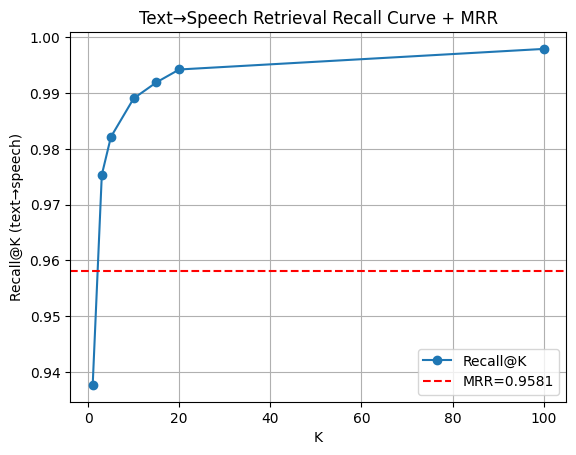

In [3]:
# Evaluation results
recall_scores, mrr_score = evaluate.run(
    ckpt_dir='/mnt/h/outputs/checkpoints/mlp_aligner_0/',
    ckpt_name=f'model_0.ckpt',
    data_dir="/mnt/h/hparl-preprocessed",
    k_values=[1, 3, 5, 10, 15, 20, 100])

#### CNN Adapter

In [2]:
adapter = CnnAdapter(
        speech_dim=384,
        text_dim=384,
        hidden_dim=256,
        kernel_sizes=(3, 5, 7),
        num_layers=2,
        pool_stride=2,
        dropout=0.1,)

checkpoint_dir = "/mnt/h/outputs/checkpoints/cnn_aligner_0"
log_dir = "./logs"
logger_name = "cnn_alignment_0"

In [ ]:
input_checkpoint_name = None
output_checkpoint_name = "model_0.ckpt"

run_training(train_ds, val_ds, adapter,
             batch_size=128,
             lr=5e-4,
             max_epochs=40,
             checkpoint_dir=checkpoint_dir,
             input_checkpoint=input_checkpoint_name,
             output_checkpoint_name=output_checkpoint_name,
             logger_name=logger_name,
             log_dir=log_dir,
             accumulate_grad_batches=4,
             num_workers=4)

[INFO] Using device: cuda
[INFO] Loading dataset from /mnt/h/hparl-preprocessed ...


Loading dataset from disk:   0%|          | 0/45 [00:00<?, ?it/s]

[INFO] Computing embeddings for test set...


Computing embeddings:   0%|          | 0/68 [00:00<?, ?it/s]

[INFO] Computing similarity matrix...


Similarity matrix:   0%|          | 0/34 [00:00<?, ?it/s]


===== TEXT → SPEECH RETRIEVAL =====


Recall@1:   0%|          | 0/34 [00:00<?, ?it/s]

Recall@1: 0.9538


Recall@3:   0%|          | 0/34 [00:00<?, ?it/s]

Recall@3: 0.9787


Recall@5:   0%|          | 0/34 [00:00<?, ?it/s]

Recall@5: 0.9841


Recall@10:   0%|          | 0/34 [00:00<?, ?it/s]

Recall@10: 0.9886


Recall@15:   0%|          | 0/34 [00:00<?, ?it/s]

Recall@15: 0.9923


Recall@20:   0%|          | 0/34 [00:00<?, ?it/s]

Recall@20: 0.9937


MRR:   0%|          | 0/34 [00:00<?, ?it/s]

MRR: 0.9677
[OK] Saved plot → /mnt/h/outputs/checkpoints/cnn_aligner_0/evaluation_results_model_0/recall_curve_text_to_speech.png
[OK] Results saved to /mnt/h/outputs/checkpoints/cnn_aligner_0/evaluation_results_model_0


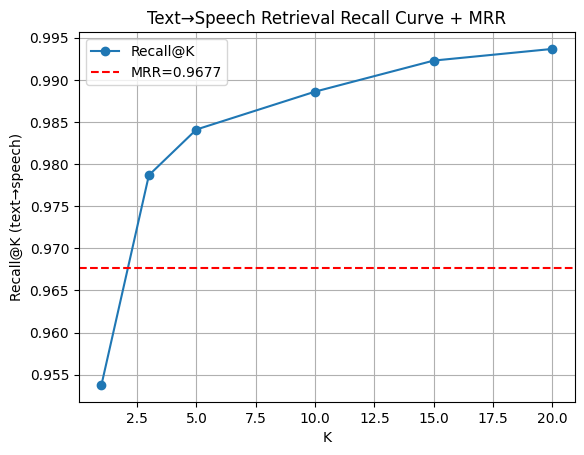

In [4]:
# Evaluation results
recall_scores, mrr_score = evaluate.run(
    ckpt_dir=checkpoint_dir,
    ckpt_name=f'model_0.ckpt',
    data_dir="/mnt/h/hparl-preprocessed",
    k_values=[1, 3, 5, 10, 15, 20])

#### LSTM Adapter

In [2]:
adapter = LstmAdapter(
        speech_dim=384,
        text_dim=384,
        hidden_dim=256,
        num_layers=3,
        dropout=0.1,)

checkpoint_dir = "/mnt/h/outputs/checkpoints/lstm_aligner_0"
log_dir = "./logs"
logger_name = "lstm_alignment_0"

adapter.save_config(checkpoint_dir)

In [1]:
input_checkpoint_name = None
output_checkpoint_name = "model_0.ckpt"

run_training(train_ds, val_ds, adapter,
             batch_size=128,
             lr=5e-4,
             max_epochs=40,
             checkpoint_dir=checkpoint_dir,
             input_checkpoint=input_checkpoint_name,
             output_checkpoint_name=output_checkpoint_name,
             logger_name=logger_name,
             log_dir=log_dir,
             accumulate_grad_batches=4,
             num_workers=4)

NameError: name 'run_training' is not defined